<a href="https://colab.research.google.com/github/CristianCosci/pytorch-grad-cam/blob/master/personal_files/grad_cam_mask_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install grad-cam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

In [3]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM,HiResCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise
    

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget



import matplotlib.pyplot as plt

In [ ]:
model = models.resnet50(pretrained=True)
target_layers = [model.layer4]

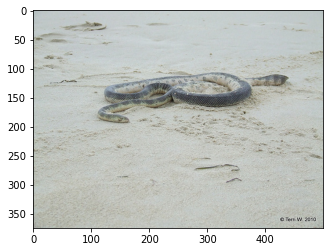

In [19]:
rgb_img = cv2.imread('/content/gdrive/MyDrive/ILSVRC2012_img_val_labeled_caffe_200/65.1.JPEG', 1)[:, :, ::-1]
origin_img = cv2.imread('/content/gdrive/MyDrive/ILSVRC2012_img_val_labeled_caffe_200/65.1.JPEG', 1)

plt.imshow(rgb_img);

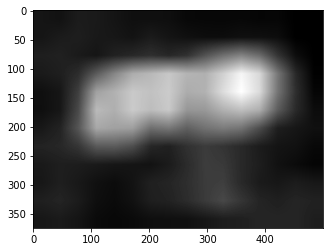

In [20]:
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

cam_algorithm = GradCAM

with cam_algorithm(model = model, target_layers = target_layers) as cam:
  cam.batch_size = 32
  grayscale_cam = cam(input_tensor=input_tensor, targets=None)

  # Here grayscale_cam has only one image in the batch
  grayscale_cam = grayscale_cam[0, :]
  grayscale_cam_mask = grayscale_cam * 255  #make range between 0-255

plt.imshow(grayscale_cam_mask, cmap='gray')

### **Apply some threshold to create a mask**

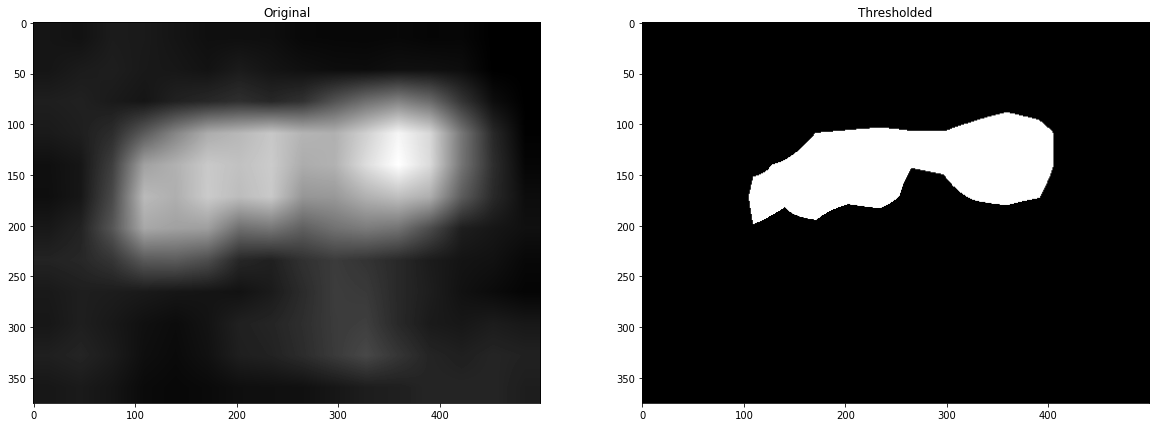

In [24]:
retval, img_thresh = cv2.threshold(grayscale_cam_mask, 170, 255, cv2.THRESH_BINARY)
mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

### **Isolating the img area using mask**

(375, 500, 3)


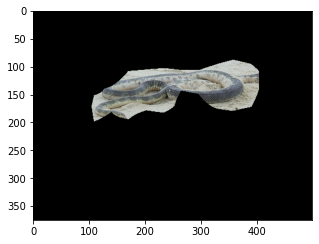

In [25]:
img_applied_mask = cv2.bitwise_and(rgb_img, rgb_img, mask = mask)

# Print the image shape.
print(img_applied_mask.shape);

# Display the image.
plt.figure(figsize = [5, 5])
plt.imshow(img_applied_mask);

### **Create an example of a filter to see the applications of created mask**

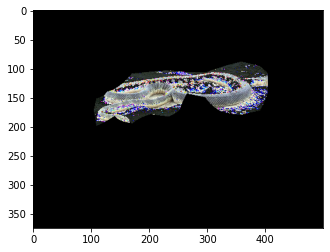

In [26]:
matrix = np.ones(img_applied_mask.shape) * 1.5
filtered_img = np.uint8(cv2.multiply(np.float64(img_applied_mask * 255), matrix))

plt.imshow(filtered_img);

### **Create an inverse mask.**

(375, 500)


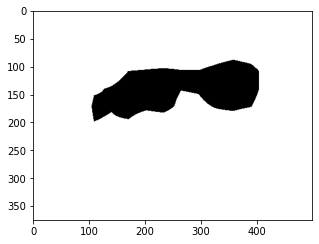

In [27]:
img_logo_mask_inv = cv2.bitwise_not(mask)

# Print the image shape.
print(img_logo_mask_inv.shape)

# Display the image.
plt.figure(figsize = [5, 5])
plt.imshow(img_logo_mask_inv, cmap='gray');

###**Isolate the foreground using the inverse mask.**

(375, 500, 3)


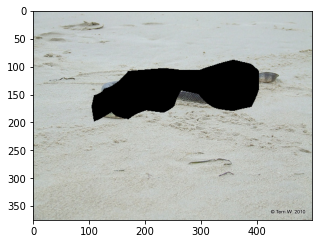

In [28]:
img_foreground = cv2.bitwise_and(origin_img, origin_img, mask = img_logo_mask_inv)

# Print the image shape.
print(img_foreground.shape)

# Display the image.
plt.figure(figsize = [5, 5])
plt.imshow(img_foreground[:, :, ::-1]);

### **Add the two previous results to obtain the final result.**

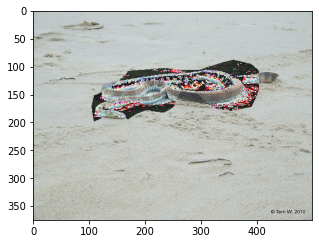

In [29]:
result = cv2.add(filtered_img,img_foreground)

# Display the image and save the the result to the file system.
plt.figure(figsize = [5, 5])
plt.imshow(result[:, :, ::-1])
# cv2.imwrite('logo_final.png', result);